In [37]:
import argparse
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class AutoDictionary(dict):
    """Implementation of perl's autovivification feature."""
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

name  = "data_"
nodes = ["5653", "55ad", "55e4", "5599", "55dd", "5565", "560b", "5632", "55b3", "5563", "630a"]
#nodes = ["5653"]
ext   = ".csv"

modes_fwd = {"0":"FSK", "1":"OQPSK", "2": "OFDM"}
modes_rev = {"FSK":"0", "OQPSK":"1", "OFDM":"2"}

# Packets per minute
items = len(nodes)
limit = 0

cca = AutoDictionary()

for node in nodes:
    print("Parsing node = {} ".format(node))
    
    # Read values from csv
    filename = name + node + ext
    data = pd.read_csv(filename, index_col=0) 
    
    # Create date column based on day and hour
    data['date'] = data['day'] + ' ' + data['hour']
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
    
    # Drop unnecessary columns
    data = data.drop(['day','hour'], axis=1)
    
    # Set date as index
    data = data.set_index(["date"])
    
    # Clip data
    data["fsk_cca_rssi"] = data["fsk_cca_rssi"].where(data["fsk_cca_rssi"] < -30, np.nan)
    data["oqpsk_cca_rssi"] = data["oqpsk_cca_rssi"].where(data["oqpsk_cca_rssi"] < -30, np.nan)
    data["ofdm_cca_rssi"] = data["ofdm_cca_rssi"].where(data["ofdm_cca_rssi"] < -30, np.nan)
    
    # Per-modulation RSSI
    cca[node]["FSK"]   = data.groupby(pd.Grouper(freq='D', level='date'))["fsk_cca_rssi"]    
    cca[node]["OQPSK"] = data.groupby(pd.Grouper(freq='D', level='date'))["oqpsk_cca_rssi"]
    cca[node]["OFDM"]  = data.groupby(pd.Grouper(freq='D', level='date'))["ofdm_cca_rssi"]

Parsing node = 5653 
Parsing node = 55ad 
Parsing node = 55e4 
Parsing node = 5599 
Parsing node = 55dd 
Parsing node = 5565 
Parsing node = 560b 
Parsing node = 5632 
Parsing node = 55b3 
Parsing node = 5563 
Parsing node = 630a 


Parsing node = 5653 
Parsing node = 55ad 
Parsing node = 55e4 
Parsing node = 5599 
Parsing node = 55dd 
Parsing node = 5565 
Parsing node = 560b 
Parsing node = 5632 
Parsing node = 55b3 
Parsing node = 5563 
Parsing node = 630a 


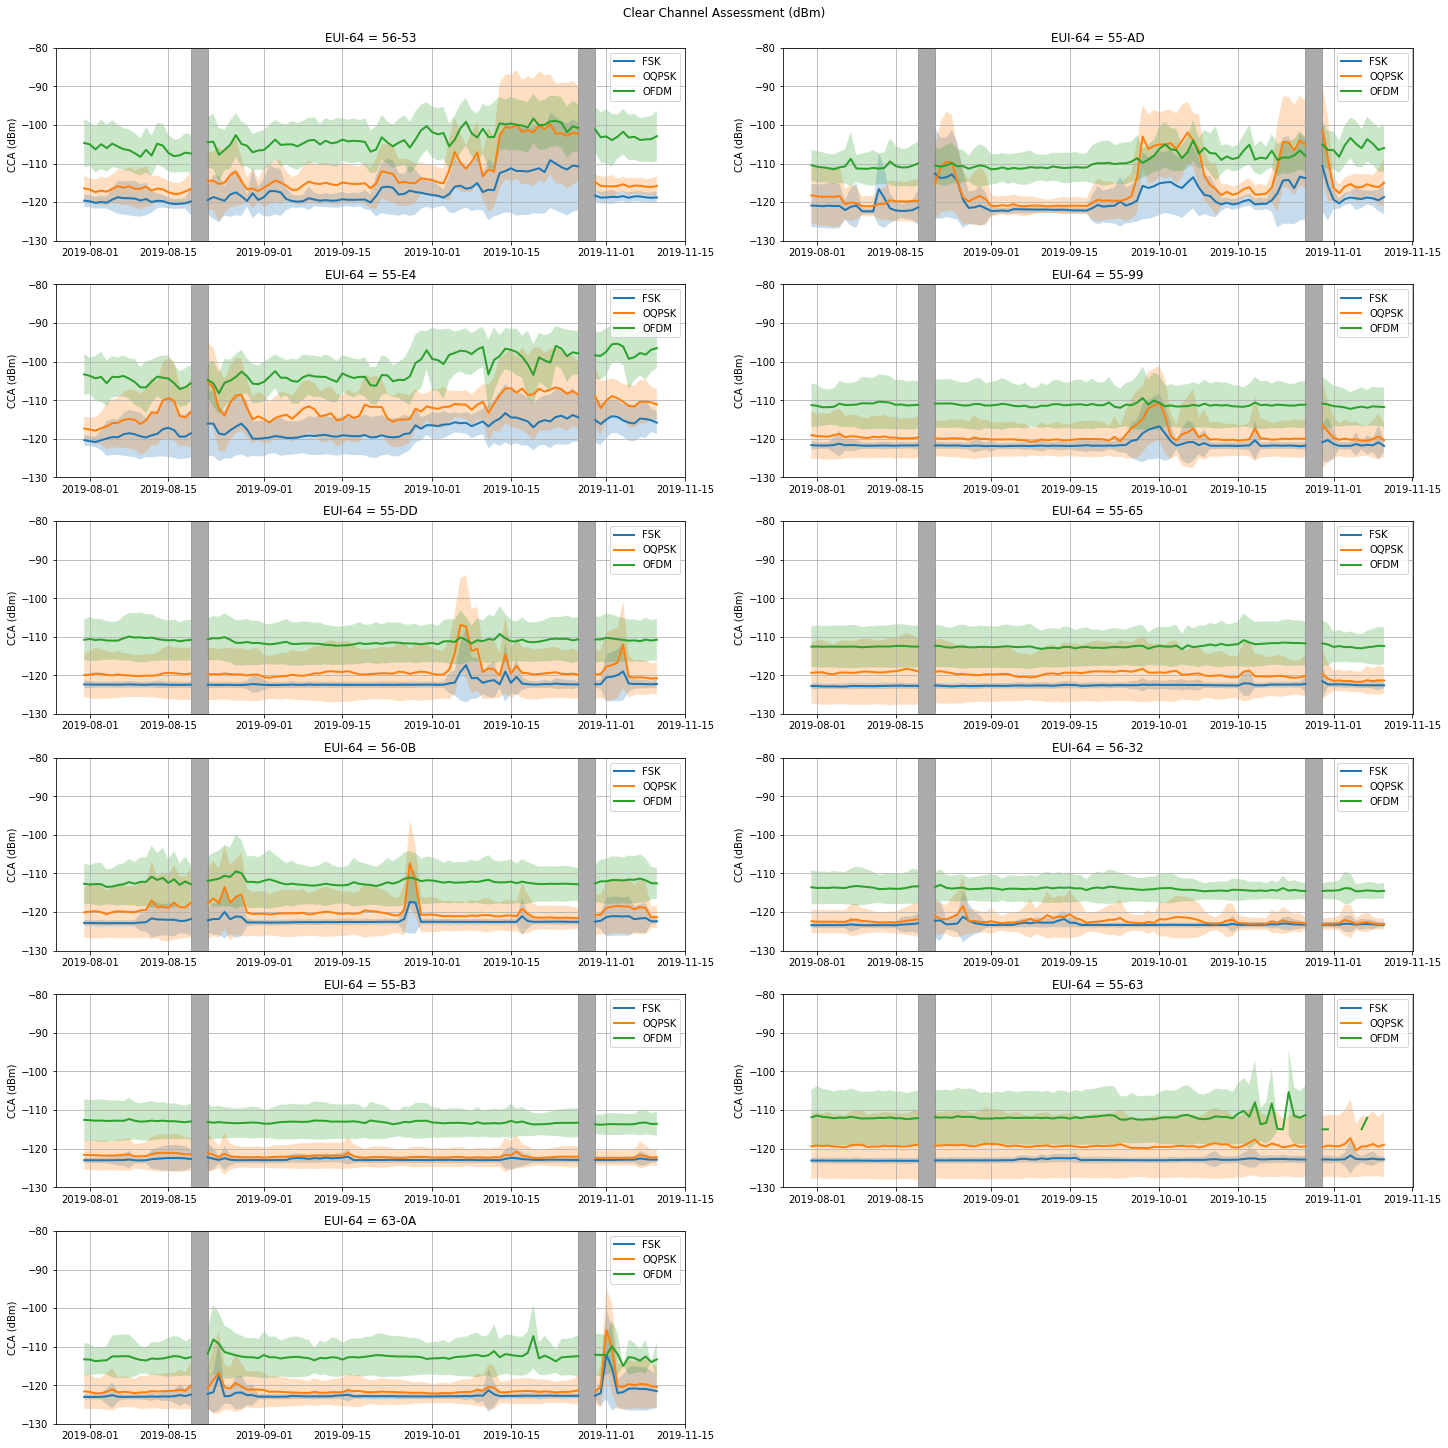

In [39]:
plt.rcParams.update({'errorbar.capsize': 1})

nrow = 6
ncol = 2

fig, axs = plt.subplots(nrow, ncol, figsize=(20,20), constrained_layout=True)

for ax, key in zip(enumerate(fig.axes), cca.keys()):
    print("Parsing node = {} ".format(key))
    
    # Recover data
    data_fsk  = cca[key]["FSK"]
    data_qpsk = cca[key]["OQPSK"]
    data_ofdm = cca[key]["OFDM"]
    
    # Recover date
    date = data_fsk.mean().reset_index()['date'].to_numpy()
    
    # Plot FSK
    mean = data_fsk.mean()
    std = data_fsk.std()
    max  = mean + std
    min  = mean - std
    ax[1].plot(date, mean, lw=2, label="FSK")
    ax[1].fill_between(date, min, max, alpha=0.25)
    
    # Plot OQPSK
    mean = data_qpsk.mean()
    std = data_qpsk.std()
    max  = mean + std
    min  = mean - std
    ax[1].plot(date, mean, lw=2, label="OQPSK")
    ax[1].fill_between(date, min, max, alpha=0.25)
    
    # Plot OFDM
    mean = data_ofdm.mean()
    std = data_ofdm.std()
    max  = mean + std
    min  = mean - std
    ax[1].plot(date, mean, lw=2, label="OFDM")
    ax[1].fill_between(date, min, max, alpha=0.25)

    # Configure plot
    ax[1].legend()
    name = (key[:2] + '-' + key[2:]).upper()
    ax[1].set_title("EUI-64 = {}".format(name))
    ax[1].fmt_xdata = mdates.DateFormatter('%d-%m')
    ax[1].grid()
    ax[1].set_ylim(-130, -80)
    ax[1].set_ylabel("CCA (dBm)")

    ax[1].axvspan(date[19], date[22], alpha=0.66, color='grey')
    ax[1].axvspan(date[88], date[91], alpha=0.66, color='grey')
    #ax[1].autofmt_xdate()

# Delete missing plot
fig.delaxes(axs[5][1])

# Set figure title
fig.suptitle("Clear Channel Assessment (dBm)")

# Save figure
plt.savefig("04_cca.png", dpi=300)